In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='notebook', style='whitegrid', palette='Dark2', font='sans-serif',
       font_scale=2.0, color_codes=True, rc={'figure.figsize':(20.7,10.27)})

In [2]:
result_folder = "results"
exps = ['cn_ad', 'cn_mci', 'mci_ad']
fts = ['gm', 'wm', 'csf', 'tissues']
folds = range(10)

In [3]:
class ColumnExtractor(object):
    def __init__(self, str_):
        self.str_ = str_

    def transform(self, X):
        return X.iloc[:, X.columns.str.contains(self.str_)]

    def fit(self, X, y=None):
        return self

In [4]:
results = []
for exp in exps:
    for fold in folds:
        path = result_folder + "/clf_concatenated_" + \
               str(fold) + "_" + exp + ".pickle"

        infile = open(path, 'rb')
        new_dict = pickle.load(infile)
        infile.close()
        for j in range(len(new_dict)):
            res = new_dict[j]['scores']
            res['exp'] = exp
            res['fold'] = fold
            res['ft'] = new_dict[j]['fts']
            res['clf'] = new_dict[j]['clf']
            
            results.append(res)
results = pd.DataFrame(results)
results.head(10)

,train,f1,acc,bacc,sens,spe,auc,exp,fold,ft,clf
0,0.945294,0.904762,0.923077,0.920123,0.904762,0.935484,0.963134,cn_ad,0,gm,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
1,0.904602,0.782609,0.807692,0.815668,0.857143,0.774194,0.937020,cn_ad,0,wm,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
2,0.959781,0.857143,0.884615,0.880184,0.857143,0.903226,0.958525,cn_ad,0,csf,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
3,0.968706,0.857143,0.884615,0.880184,0.857143,0.903226,0.975422,cn_ad,0,tissues,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
4,0.954671,0.772727,0.803922,0.804762,0.809524,0.800000,0.915873,cn_ad,1,gm,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
5,0.908500,0.780488,0.823529,0.814286,0.761905,0.866667,0.898413,cn_ad,1,wm,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
6,0.958598,0.818182,0.843137,0.845238,0.857143,0.833333,0.952381,cn_ad,1,csf,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
7,0.973023,0.850000,0.882353,0.871429,0.809524,0.933333,0.946032,cn_ad,1,tissues,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
8,0.938757,0.878049,0.901961,0.895238,0.857143,0.933333,0.969841,cn_ad,2,gm,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
9,0.895245,0.829268,0.862745,0.854762,0.809524,0.900000,0.934921,cn_ad,2,wm,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."


In [5]:
def get_roc_probs(df, exp, ft):
    auc, tprs, roc_values = [], [], []
    df = df[df['exp']==exp]
    mean_fpr = np.linspace(0, 1, 100)
    for fold in range(10):
        # Best result
        df_fold = df[(df.fold==fold) & (df.ft == ft)]
        name_train = 'fts_train_{}_{}.csv'.format(str(fold),exp)
        name_test = 'fts_test_{}_{}.csv'.format(str(fold),exp)
        df_train= pd.read_csv(os.path.join(folder, name_train))
        df_test= pd.read_csv(os.path.join(folder, name_test))

        X_train = df_train.iloc[:,1:-1]
        y_train = df_train.iloc[:,-1]

        X_test = df_test.iloc[:,1:-1]
        y_test = df_test.iloc[:,-1]

        c = df_fold['clf'].values[0].best_params_['clf__C']
        d = df_fold['clf'].values[0].best_params_['clf__degree']

        pipe = Pipeline([("sel", ColumnExtractor(str_= 'tissues')),
                        ("scale", StandardScaler()),
                        ('clf', svm.SVC(gamma='scale',
                                        kernel='poly',
                                        class_weight='balanced',
                                        probability=True,
                                        C=c, degree=d))])

        pipe.fit(X_train, y_train)

        y_score = pipe.predict_proba(X_test)[:, 1]
        auc_ = roc_auc_score(y_test, y_score)
        fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        auc.append(auc_)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    roc_values.append([np.linspace(0, 1, 100), mean_tpr, auc, tprs])
    return roc_values

In [6]:
def plot_roc(roc_values, save=False):
        sns.set(context='paper', style='white', 
                font='sans-serif', font_scale=3, 
                rc={'figure.figsize':(12, 10)})

        mean_fpr, mean_tpr, aucs, tprs = roc_values['cn_mci'][0]

        plt.plot(mean_fpr, mean_tpr,
                label=r'%s = %0.2f' % ('CNxMCI', np.mean(aucs)),
                lw=2)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.1,)

        mean_fpr, mean_tpr, aucs, tprs = roc_values['mci_ad'][0]
        plt.plot(mean_fpr, mean_tpr,
                label=r'%s = %0.2f' % ('MCIxAD', np.mean(aucs)),
                lw=2)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.1,)

        mean_fpr, mean_tpr, aucs, tprs = roc_values['cn_ad'][0]

        plt.plot(mean_fpr, mean_tpr,
                 label=r'%s = %0.2f' % ('CNxAD', np.mean(aucs)),
                 lw=2)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.1,)


        plt.xlim([0., 1.0])
        plt.ylim([0., 1.0])
        plt.xlabel('1-specificity')
        plt.ylabel('Sensitivity')
        plt.legend(loc="lower right", fontsize ='x-small')
        if save:
                plt.savefig("images/roc_final.pdf", bbox_inches='tight', dpi=300)
        plt.show()

0.7299292307692308


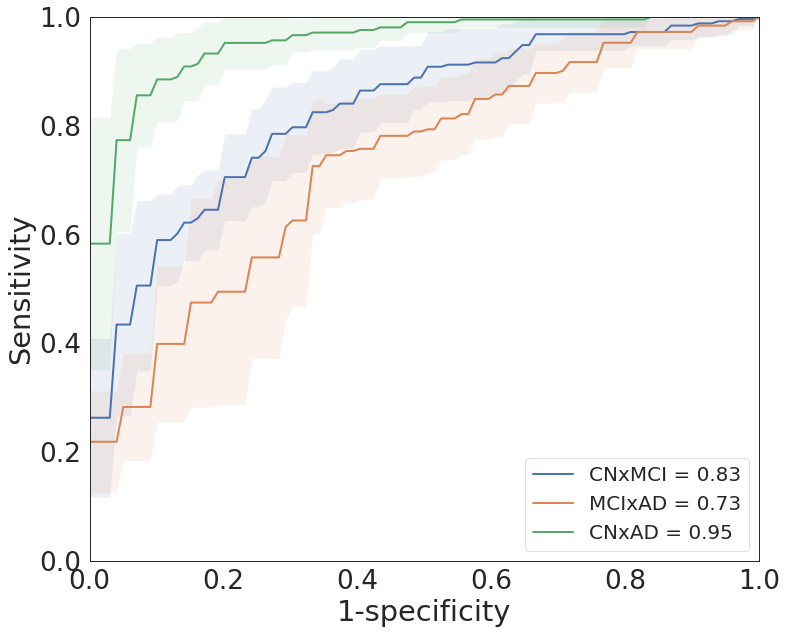

In [9]:
folder = 'image_train_test_data'
roc_values = {}
for exp in exps:
    roc_values[exp] = get_roc_probs(results, exp, ft='tissues')
print(np.mean(roc_values['mci_ad'][0][3]))
plot_roc(roc_values, save=True)

In [10]:
outfile = open('images/roc_cnad.pickle', 'wb')
pickle.dump(roc_values['cn_ad'][0], outfile)
outfile.close()

outfile = open('images/roc_mciad.pickle', 'wb')
pickle.dump(roc_values['mci_ad'][0], outfile)
outfile.close()

outfile = open('images/roc_cnmci.pickle', 'wb')
pickle.dump(roc_values['cn_mci'][0], outfile)
outfile.close()